In [ ]:
! pip install xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 폰트 설치
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
# 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [ ]:
# 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

지역 목록 : 서울특별시 부산광역시 대구광역시 인천광역시 광주광역시 대전광역시 울산광역시 세종시 경기도 강원도 충청북도 충청남도 전라북도 전라남도 경상북도 경상남도 제주도 지역 : 서울특별시
서울특별시 상세 지역 목록 : 종로구 중구 용산구 성동구 광진구 동대문구 중랑구 성북구 강북구 도봉구 노원구 은평구 서대문구 마포구 양천구 강서구 구로구 금천구 영등포구 동작구 관악구 서초구 강남구 송파구 강동구 상세 지역 : 종로구
서울특별시 종로구 충전소 현황이 완성되었습니다.



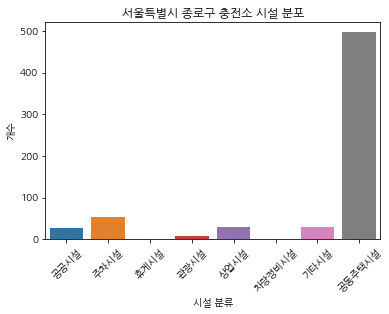

In [ ]:
import os
import sys
import urllib.request
import xmltodict
import datetime
import time
import json
import pandas as pd
import ssl
import folium
import seaborn as sns
import matplotlib.pyplot as plt

ssl._create_default_https_context = ssl._create_unverified_context

ServiceKey="5wUibcgyMHJ%2FNqYkVWaxunMQSIZ6tONQ8EJ55I47cV86EUNASc5g3X9dF1Bzr5SqqfprwYvMEnhnHlZ8hwpctQ%3D%3D"

df_area = pd.read_excel(io='/content/drive/MyDrive/Colab Notebooks/법정동코드.xlsx', header=None, names=['zcode','zcode_name','zscode','zscode_name'])

def getData(zcode, zscode):
  total_data = []
  service_url = 'https://apis.data.go.kr/B552584/EvCharger/getChargerInfo'
  parameters = '?serviceKey=' + ServiceKey   #인증키
  parameters += '&pageNo=1&numOfRows=9999&zcode=' + zcode
  parameters += '&zscode=' + zscode
  url = service_url + parameters

  response = urllib.request.urlopen(url)
  results = response.read().decode('utf-8')
  results_to_json = xmltodict.parse(results)
  data = json.loads(json.dumps(results_to_json))
  total_data.extend(data['response']['body']['items']['item'])

  df_total_temp = pd.DataFrame(total_data)
  df_total = df_total_temp

  return df_total

def getTotalData():
  total_data = []
  area_array_temp = df_area.drop_duplicates(['zcode'])
  area_array = list(map(str, area_array_temp['zcode'].to_numpy()))

  for z in area_array:
    service_url = 'https://apis.data.go.kr/B552584/EvCharger/getChargerInfo'
    parameters = '?serviceKey=' + ServiceKey   #인증키
    parameters += '&pageNo=1&numOfRows=9999&zcode=' + z

    detail_area_array_temp = df_area[df_area['zcode'] == int(z)]
    detail_area_array = list(map(str, detail_area_array_temp['zscode'].to_numpy()))

    for zs in detail_area_array:
      parameters += '&zscode=' + zs
      url = service_url + parameters

      response = urllib.request.urlopen(url)
      results = response.read().decode('utf-8')
      results_to_json = xmltodict.parse(results)
      data = json.loads(json.dumps(results_to_json))
      total_data.extend(data['response']['body']['items']['item'])
      parameters = parameters[:-13]
      
  df_total = pd.DataFrame(total_data)
  df_total.to_csv('/content/total_data.csv')

def marker(data, color, icon, map):
  for name, addr, lat, lng, free, chtype in zip(data.statNm, data.addr, data.lat, data.lng, data.parkingFree, data.chgerType):
    free_val = ''
    if free == 'Y':
      free_val = '무료'
    else:
      free_val = '유료'

    chtype = int(chtype)
    ch_array = ['DC 차데모', 'AC 완속', 'DC 차데모 + AC3 상', 'DC 콤보', 'DC 차데모 + DC 콤보', 'DC 차데모 + AC3 상 + DC 콤보', 'AC3 상', 'H2']
    charger_type = ch_array[chtype - 1]

    html = f'''
            <h2>{name}</h2>
            <p>주소 : {addr}</p>
            <p>주차료 : {free_val}</p>
            <p>충전기 타입 : {charger_type}</p>
            '''
    iframe = folium.IFrame(html, width=300, height=200)
    popup = folium.Popup(iframe, max_width=400)
    folium.Marker([lat, lng], popup=popup, tooltip=name, icon=folium.Icon(color, icon=icon, prefix='fa')).add_to(map)


def main():
  # 지역 코드
  area_array_temp = df_area.drop_duplicates(['zcode'])
  area_array = area_array_temp['zcode_name'].to_numpy()
  print('지역 목록 :', end=' ')
  for a in area_array:
    print(a, end=' ')
  zcode_temp = input('지역 : ')
  if zcode_temp not in area_array:
    print('올바른 지역이 아닙니다.')
    return
  zcode = str(area_array_temp[area_array_temp['zcode_name'] == zcode_temp].iat[0,0])

  if zcode_temp == '세종시':
    zscode = '36110'
    zscode_temp = ''
  else:
    # 상세 지역 코드
    detail_area_array_temp = df_area[df_area['zcode_name'] == zcode_temp]
    detail_area_array = detail_area_array_temp['zscode_name'].to_numpy()
  
    print(zcode_temp + ' 상세 지역 목록 :', end=' ')
    for a in detail_area_array:
      print(a, end=' ')
    zscode_temp = input('상세 지역 : ')
    if zscode_temp not in detail_area_array:
      print('올바른 상세 지역이 아닙니다.')
      return
    zscode = str(detail_area_array_temp[detail_area_array_temp['zscode_name'] == zscode_temp].iat[0,2])

  # 데이터 불러오기
  data = getData(zcode, zscode)
  
  data_avail = data[data['stat'] == '2']
  data_using = data[data['stat'] == '3']

  smap = folium.Map(location=[37.4493812, 126.6573386], zoom_start=10, tiles='Stamen Terrain')

  geo='/content/drive/MyDrive/Colab Notebooks/GeoJSON/' + zcode_temp + '.json'
  total_data_temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/total_data.csv', low_memory=False)
  total_data = total_data_temp[total_data_temp['zcode'] == int(zcode)].groupby('zscode', as_index=False).count()
  total_data['zscode'] = total_data['zscode'].astype(str)

  marker(data_avail, 'green', 'check', smap)
  marker(data_using, 'red', 'times', smap)
  folium.Choropleth(geo_data=geo, data=total_data, columns=['zscode','lat'], fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.3,
                    threshold_scale=[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000], key_on='feature.properties.COL_ADM_SE').add_to(smap)
  
  smap.save('/content/' + zcode_temp + '_' + zscode_temp + '_충전소_현황.html')
  print('{0} {1} 충전소 현황이 완성되었습니다.'.format(zcode_temp, zscode_temp))
  print()
  ax = sns.countplot(data=data, x='kind', order=['A0','B0','C0','D0','E0','F0','G0','H0'])
  ax.set_title('{0} {1} 충전소 시설 분포'.format(zcode_temp, zscode_temp))
  ax.set_xlabel('시설 분류')
  ax.set_ylabel('개수')
  ax.set_xticklabels(labels=['공공시설', '주차시설', '휴게시설', '관광시설', '상업시설', '차량정비시설', '기타시설', '공동주택시설'], rotation=45)
  

if __name__ == '__main__':
  main()